In [4]:
from dataloader import AmazonDataset
import models
from models import DistMulti, TransE
from training import TrainIterater
from evaluate import Evaluater

import optuna
import numpy as np
import pickle
import time

import torch
from importlib import reload

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
# ハイパラ
# 
# embed_dim
# batch_size
# weight_decay, lr, warmup, lr_decay_every, lr_decay_rate
# kg embed model
model_name = 'TransE'
dataset = AmazonDataset('./data', model_name='TransE')
def objective(trial):
    start = time.time()
    
    relation_size = len(set(list(dataset.triplet_df['relation'].values)))
    entity_size = len(dataset.entity_list)
    embedding_dim = trial.suggest_discrete_uniform('embedding_dim', 16, 128, 16)
    model = TransE(int(embedding_dim), relation_size, entity_size).to(device)
    
    batch_size = trial.suggest_int('batch_size', 128, 512, 128)
    iterater = TrainIterater(batch_size=int(batch_size), model_name=model_name)
    
    lr= trial.suggest_loguniform('lr', 1e-4, 1e-2)
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-2)
    warmup = trial.suggest_int('warmup', 100, 500)
    #warmup = trial.suggest_int('warmup', 1, 5)
    lr_decay_every = trial.suggest_int('lr_decay_every', 1, 10)
    lr_decay_rate = trial.suggest_uniform('lr_decay_rate', 0.5, 1)
    
    score =iterater.iterate_epoch(model, lr=lr, epoch=3000, weight_decay=weight_decay, warmup=warmup,
                           lr_decay_rate=lr_decay_rate, lr_decay_every=lr_decay_every, eval_every=100)
    
    mi, sec = time_since(time.time() - start)
    print('{}m{}sec'.format(mi, sec))
    
    return -1 * score

epoch: 99  precision: 0.23495315861460533
epoch: 199  precision: 0.28545392004164116
epoch: 299  precision: 0.24622142596247568
epoch: 399  precision: 0.21022681061156318
epoch: 499  precision: 0.20793785613340576
epoch: 599  precision: 0.20778263700860497
epoch: 699  precision: 0.21877945644827249
epoch: 799  precision: 0.22084943966623502
epoch: 899  precision: 0.2296277194761497
epoch: 999  precision: 0.23712635848153021
epoch: 1099  precision: 0.23332745891192563
epoch: 1199  precision: 0.2355435526124536
epoch: 1299  precision: 0.23622364296717366
epoch: 1399  precision: 0.23220060819565336
epoch: 1499  precision: 0.22922318627280835
epoch: 1599  precision: 0.22939745164772324
epoch: 1699  precision: 0.22956874506711913
epoch: 1799  precision: 0.2290564744084826
epoch: 1899  precision: 0.22912541577117326
epoch: 1999  precision: 0.2291976392798103
epoch: 2099  precision: 0.2289979535727637
epoch: 2199  precision: 0.22913110516364127
epoch: 2299  precision: 0.22909797502847032
epoc

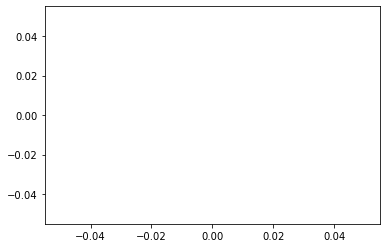

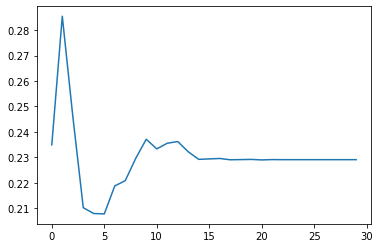

[W 2020-07-05 11:26:30,587] Setting status of trial#0 as TrialState.FAIL because of the following error: NameError("name 'time_since' is not defined")
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/optuna/study.py", line 734, in _run_trial
    result = func(trial)
  File "<ipython-input-8-a4bd7fae7fb4>", line 30, in objective
    mi, sec = time_since(time.time() - start)
NameError: name 'time_since' is not defined


NameError: name 'time_since' is not defined

In [9]:
study = optuna.create_study()
study.optimize(objective, n_trials=20)

In [7]:
df = study.trials_dataframe() # pandasのDataFrame形式
df.to_csv('./hyparams_result.csv')

In [ ]:
# save best params 
with open('best_param.pickle', 'wb') as f:
    pickle.dump(study.best_params, f)

In [9]:
study.best_params

{'embedding_dim': 48.0,
 'batch_size': 256,
 'lr': 0.00027575703280897554,
 'weight_decay': 0.008211142725366551,
 'warmup': 5,
 'lr_decay_every': 8,
 'lr_decay_rate': 0.6785466714298021}